# Amazon Forecast: predicting time-series at scale

Forecasting is used in a variety of applications and business use cases: For example, retailers need to forecast the sales of their products to decide how much stock they need by location, Manufacturers need to estimate the number of parts required at their factories to optimize their supply chain, Businesses need to estimate their flexible workforce needs, Utilities need to forecast electricity consumption needs in order to attain an efficient energy network, and 
enterprises need to estimate their cloud infrastructure needs.

<img src="common/images/amazon_forecast.png">


# Table of Contents

* Step 0: [Setting up](#setup)
* Step 1: [Preparing the Datasets](#prepare)
* Step 2: [Importing the Data](#import)
 * Step 2a: [Creating a Dataset Group](#create)
 * Step 2b: [Creating a Target Dataset](#target)
 * Step 2c: [Creating a Related Dataset](#related)
 * Step 2d: [Update the Dataset Group](#update)
 * Step 2e: [Creating a Target Time Series Dataset Import Job](#targetImport)
 * Step 2f: [Creating a Related Time Series Dataset Import Job](#relatedImport)
* Step 3: [Choosing an Algorithm and Evaluating its Performance](#algo)
 * Step 3a: [Choosing DeepAR+](#DeepAR)
 * Step 3b: [Choosing Prophet](#prophet)
* Step 4: [Computing Error Metrics from Backtesting](#error)
* Step 5: [Creating a Forecast](#forecast)
* Step 6: [Querying the Forecasts](#query)
* Step 7: [Exporting the Forecasts](#export)
* Step 8: [Clearning up your Resources](#cleanup)


#  First let us setup Amazon Forecast<a class="anchor" id="setup">

This section sets up the permissions and relevant endpoints.

In [1]:
import sys
import os

import boto3
import pandas as pd
import matplotlib.pyplot as plt

# importing forecast notebook utility from notebooks/common directory
sys.path.insert( 0, os.path.abspath("common") )
import util

plt.rcParams['figure.figsize'] = (15.0, 5.0)

Configure the S3 bucket name and region name for this lesson.

- If you don't have an S3 bucket, create it first on S3.
- Although we have set the region to us-east-1 as a default value below, you can choose any of the regions that the service is available in.

In [2]:
text_widget_bucket = util.create_text_widget( "bucket_name", "input your S3 bucket name" )
text_widget_region = util.create_text_widget( "region", "input region name.", default_value="us-east-1" )

Text(value='', description='bucket_name', placeholder='input your S3 bucket name')

Text(value='us-east-1', description='region', placeholder='input region name.')

In [3]:
bucket_name = text_widget_bucket.value
assert bucket_name, "bucket_name not set."

region = text_widget_region.value
assert region, "region not set."

In [4]:
session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast') 
forecast_query = session.client(service_name='forecastquery')

In [5]:
# Create the role to provide to Amazon Forecast.
role_name = "ForecastNotebookRole-RelatedTimeSeries"
role_arn = util.get_or_create_iam_role( role_name = role_name )

Created arn:aws:iam::457927431838:role/ForecastNotebookRole-RelatedTimeSeries
Attaching policies
Waiting for a minute to allow IAM role policy attachment to propagate
Done.


# Overview

<img src="images/outline.png">

<img src="common/images/forecast_workflow.png">

The above figure summarizes the key workflow of using Forecast. 

# Step 1: Preparing the Datasets<a class="anchor" id="prepare">

In [6]:
bike_df = pd.read_csv("data/train.csv", dtype = object)
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1


In [7]:
bike_df['count'] = bike_df['count'].astype('float')
bike_df['workingday'] = bike_df['workingday'].astype('float')

We take about two and a half week's of hourly data for demonstration, just for the purpose that there's no missing data in the whole range.

In [10]:
bike_df_small = bike_df[-2*7*24-24*3:].copy()
bike_df_small['item_id'] = "bike_12"
bike_df_small.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,item_id
10478,2012-12-03 00:00:00,4,0,1.0,2,17.22,21.21,82,11.0014,3,18,21.0,bike_12
10479,2012-12-03 01:00:00,4,0,1.0,1,16.4,20.455,82,8.9981,2,11,13.0,bike_12
10480,2012-12-03 02:00:00,4,0,1.0,1,17.22,21.21,77,11.0014,1,9,10.0,bike_12
10481,2012-12-03 03:00:00,4,0,1.0,1,15.58,19.695,87,0,2,6,8.0,bike_12
10482,2012-12-03 04:00:00,4,0,1.0,1,14.76,18.94,93,0,1,4,5.0,bike_12


Let us plot the time series first.

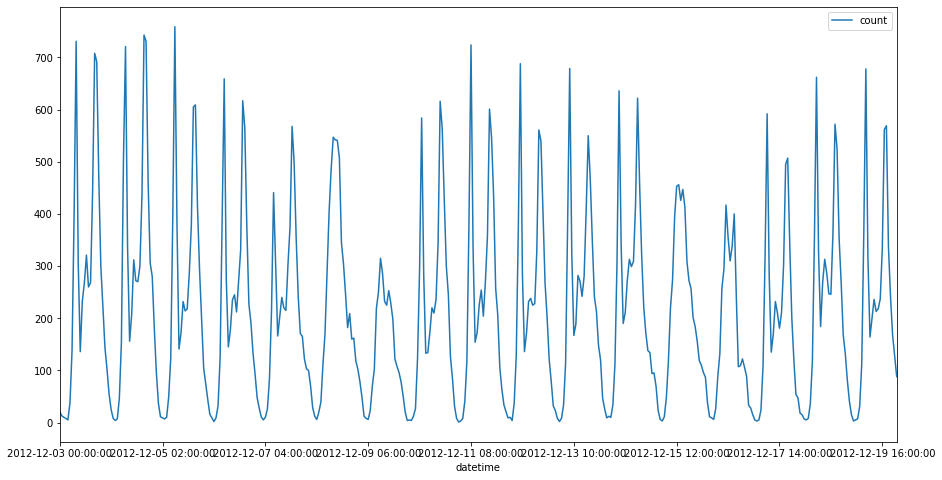

In [9]:
bike_df_small.plot(x='datetime', y='count', figsize=(15, 8))

We can see that the target time series seem to have a drop over weekends. Next let's plot both the target time series and the related time series that indicates whether today is a `workday` or not. More precisely, $r_t = 1$ if $t$ is a work day and 0 if not.

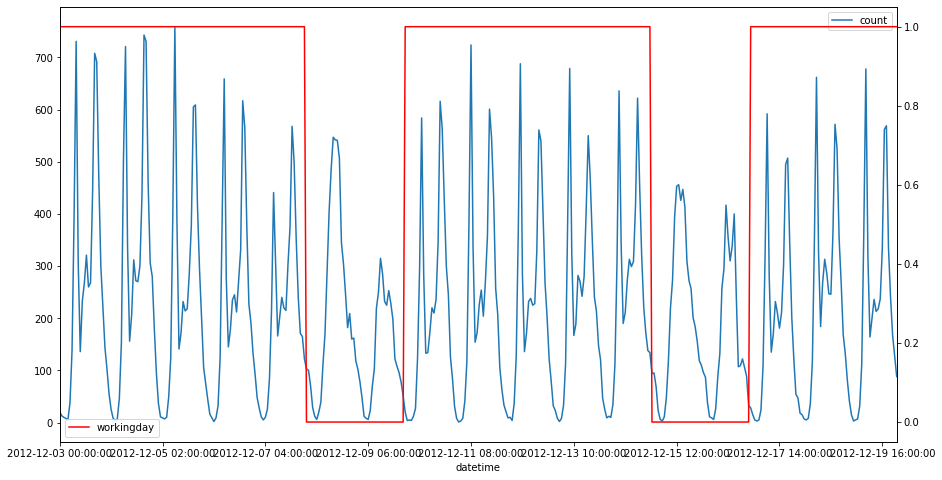

In [11]:
plt.figure(figsize=(15, 8))
ax = plt.gca()
bike_df_small.plot(x='datetime', y='count', ax=ax);
ax2 = ax.twinx()
bike_df_small.plot(x='datetime', y='workingday', color='red', ax=ax2);

Notice that to use the related time series, we need to ensure that the related time series covers the whole target time series, as well as the future values as specified by the forecast horizon. More precisely, we need to make sure:
```
len(related time series) >= len(target time series) + forecast horizon
```
Basically, all items need to have data start at or before the item start date, and have data until the forecast horizon (i.e. the latest end date across all items + forecast horizon).  Additionally, there should be no missing values in the related time series. The following picture illustrates the desired logic. 

<img src="images/rts_viz.png">

For more details regarding how to prepare your Related Time Series dataset, please refer to the public documentation <a href="https://docs.aws.amazon.com/forecast/latest/dg/related-time-series-datasets.html">here</a>. 

Suppose in this particular example, we wish to forecast for the next 24 hours, and thus we generate the following dataset.

In [12]:
target_df = bike_df_small[['item_id', 'datetime', 'count']][:-24]
rts_df = bike_df_small[['item_id', 'datetime', 'workingday']]

In [13]:
target_df.head(5)

,item_id,datetime,count
10478,bike_12,2012-12-03 00:00:00,21.0
10479,bike_12,2012-12-03 01:00:00,13.0
10480,bike_12,2012-12-03 02:00:00,10.0
10481,bike_12,2012-12-03 03:00:00,8.0
10482,bike_12,2012-12-03 04:00:00,5.0


As we can see, the length of the related time series is equal to the length of the target time series plus the forecast horizon. 

In [14]:
print(len(target_df), len(rts_df))
assert len(target_df) + 24 == len(rts_df), "length doesn't match"

384 408


Next we check whether there are "holes" in the related time series.  

In [15]:
assert len(rts_df) == len(pd.date_range(
    start=list(rts_df['datetime'])[0],
    end=list(rts_df['datetime'])[-1],
    freq='H'
)), "missing entries in the related time series"

Everything looks fine, and we plot both time series again. As it can be seen, the related time series (indicator of whether the current day is a workday or not) is longer than the target time series.  The binary working day indicator feature is a good example of a related time series, since it is known at all future time points.  Other examples of related time series include holiday and promotion features.

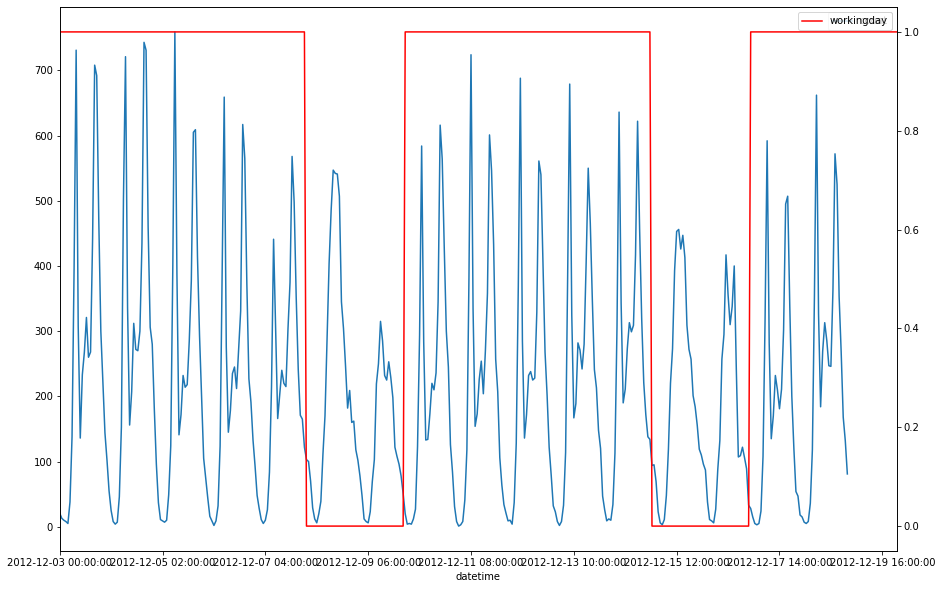

In [16]:
plt.figure(figsize=(15, 10))
ax = plt.gca()
target_df.plot(x='datetime', y='count', ax=ax);
ax2 = ax.twinx()
rts_df.plot(x='datetime', y='workingday', color='red', ax=ax2);

In [17]:
target_df.to_csv("data/bike_small.csv", index= False, header = False)
rts_df.to_csv("data/bike_small_rts.csv", index= False, header = False)

In [18]:
s3 = session.client('s3')

In [19]:
key = "bike_small"

s3.upload_file(Filename="data/bike_small.csv", Bucket = bucket_name, Key = f"{key}/bike.csv")
s3.upload_file(Filename="data/bike_small_rts.csv", Bucket = bucket_name, Key = f"{key}/bike_rts.csv")

# Step 2. Importing the Data<a class="anchor" id="import">


Now we are ready to import the datasets into the Forecast service. Starting from the raw data, Amazon Forecast automatically extracts the dataset that is suitable for forecasting. As an example, a retailer normally records the transaction record such as
<img src="images/data_format.png">
<img src="images/timestamp.png">



In [32]:
import secrets
import string
project = "bike_rts_demo_{}".format(''.join(secrets.choice(string.ascii_lowercase + string.digits) for i in range(4)))
idx = 4
print(project)

bike_rts_demo_bhef_


In [33]:
s3_data_path = f"s3://{bucket_name}/{key}"

Below, we specify key input data and forecast parameters

In [34]:
freq = "H"
forecast_horizon = 24
timestamp_format = "yyyy-MM-dd HH:mm:ss"
delimiter = ','

## Step 2a. Creating a Dataset Group<a class="anchor" id="create">
First let's create a dataset group and then update it later to add our datasets.

In [35]:
dataset_group = f"{project}_gp_{idx}"
dataset_arns = []
create_dataset_group_response = forecast.create_dataset_group(Domain="RETAIL",
                                                          DatasetGroupName=dataset_group,
                                                          DatasetArns=dataset_arns)

In [36]:
print(f'Creating dataset group {dataset_group}')

Creating dataset group bike_rts_demo_bhef__gp_4


In [37]:
dataset_group_arn = create_dataset_group_response['DatasetGroupArn']

In [38]:
forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

{'DatasetGroupName': 'bike_rts_demo_bhef__gp_4',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:457927431838:dataset-group/bike_rts_demo_bhef__gp_4',
 'DatasetArns': [],
 'Domain': 'RETAIL',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 5, 18, 0, 27, 40, 696000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 5, 18, 0, 27, 40, 696000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'a0efe345-cc9a-4d28-9b41-a86367e9bb89',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 18 May 2020 07:28:18 GMT',
   'x-amzn-requestid': 'a0efe345-cc9a-4d28-9b41-a86367e9bb89',
   'content-length': '271',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

## Step 2b. Creating a Target Dataset<a class="anchor" id="target">
In this example, we will define a target time series. This is a required dataset to use the service.

Below we specify the target time series name af_demo_ts_4.

In [39]:
ts_dataset_name = f"{project}_ts_{idx}"
print(ts_dataset_name)

bike_rts_demo_bhef__ts_4


Next, we specify the schema of our dataset below. Make sure the order of the attributes (columns) matches the raw data in the files. We follow the same three attribute format as the above example.

In [40]:
ts_schema_val = [{"AttributeName": "item_id", "AttributeType": "string"},
              {"AttributeName": "timestamp", "AttributeType": "timestamp"},
              {"AttributeName": "demand", "AttributeType": "float"}]
ts_schema = {"Attributes": ts_schema_val}

In [41]:
print(f'Creating target dataset {ts_dataset_name}')

Creating target dataset bike_rts_demo_bhef__ts_4


In [42]:
response = forecast.create_dataset(Domain="RETAIL",
                               DatasetType='TARGET_TIME_SERIES',
                               DatasetName=ts_dataset_name,
                               DataFrequency=freq,
                               Schema=ts_schema
                              )

In [43]:
ts_dataset_arn = response['DatasetArn']

In [44]:
forecast.describe_dataset(DatasetArn=ts_dataset_arn)

{'DatasetArn': 'arn:aws:forecast:us-east-1:457927431838:dataset/bike_rts_demo_bhef__ts_4',
 'DatasetName': 'bike_rts_demo_bhef__ts_4',
 'Domain': 'RETAIL',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'item_id',
    'AttributeType': 'string'},
   {'AttributeName': 'timestamp', 'AttributeType': 'timestamp'},
   {'AttributeName': 'demand', 'AttributeType': 'float'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 5, 18, 0, 28, 57, 499000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 5, 18, 0, 28, 57, 499000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '33ad37b6-4afd-4287-8e3c-dba9a152e17b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 18 May 2020 07:29:01 GMT',
   'x-amzn-requestid': '33ad37b6-4afd-4287-8e3c-dba9a152e17b',
   'content-length': '503',
   'connection': 'keep-alive'},
  'RetryAttem

## Step 2c. Creating a Related Dataset<a class="anchor" id="related">
In this example, we will define a related time series.

Specify the related time series name af_demo_rts_4.

In [45]:
rts_dataset_name = f"{project}_rts_{idx}"
print(rts_dataset_name)

bike_rts_demo_bhef__rts_4


Specify the schema of your dataset here. Make sure the order of columns matches the raw data files. We follow the same three column format as the above example.

In [46]:
rts_schema_val = [{"AttributeName": "item_id", "AttributeType": "string"},
              {"AttributeName": "timestamp", "AttributeType": "timestamp"},
              {"AttributeName": "price", "AttributeType": "float"}]
rts_schema = {"Attributes": rts_schema_val}

In [47]:
print(f'Creating related dataset {rts_dataset_name}')

Creating related dataset bike_rts_demo_bhef__rts_4


In [48]:
response = forecast.create_dataset(Domain="RETAIL",
                               DatasetType='RELATED_TIME_SERIES',
                               DatasetName=rts_dataset_name,
                               DataFrequency=freq,
                               Schema=rts_schema
                              )

In [49]:
rts_dataset_arn = response['DatasetArn']

In [50]:
forecast.describe_dataset(DatasetArn=rts_dataset_arn)

{'DatasetArn': 'arn:aws:forecast:us-east-1:457927431838:dataset/bike_rts_demo_bhef__rts_4',
 'DatasetName': 'bike_rts_demo_bhef__rts_4',
 'Domain': 'RETAIL',
 'DatasetType': 'RELATED_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'item_id',
    'AttributeType': 'string'},
   {'AttributeName': 'timestamp', 'AttributeType': 'timestamp'},
   {'AttributeName': 'price', 'AttributeType': 'float'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 5, 18, 0, 29, 19, 973000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 5, 18, 0, 29, 19, 973000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'cd602187-b53e-4e0c-be18-491d14636834',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 18 May 2020 07:29:21 GMT',
   'x-amzn-requestid': 'cd602187-b53e-4e0c-be18-491d14636834',
   'content-length': '505',
   'connection': 'keep-alive'},
  'RetryAtt

## Step 2d. Updating the dataset group with the datasets we created<a class="anchor" id="update">
You can have multiple datasets under the same dataset group. Update it with the datasets we created before.

In [51]:
dataset_arns = []
dataset_arns.append(ts_dataset_arn)
dataset_arns.append(rts_dataset_arn)
forecast.update_dataset_group(DatasetGroupArn=dataset_group_arn, DatasetArns=dataset_arns)

{'ResponseMetadata': {'RequestId': '03e4fa11-2e07-42fd-ac7a-a9de3e121c1a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 18 May 2020 07:29:34 GMT',
   'x-amzn-requestid': '03e4fa11-2e07-42fd-ac7a-a9de3e121c1a',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [52]:
forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

{'DatasetGroupName': 'bike_rts_demo_bhef__gp_4',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:457927431838:dataset-group/bike_rts_demo_bhef__gp_4',
 'DatasetArns': ['arn:aws:forecast:us-east-1:457927431838:dataset/bike_rts_demo_bhef__ts_4',
  'arn:aws:forecast:us-east-1:457927431838:dataset/bike_rts_demo_bhef__rts_4'],
 'Domain': 'RETAIL',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 5, 18, 0, 27, 40, 696000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 5, 18, 0, 29, 34, 662000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '6b29bcdc-1198-4d34-9672-41d06f339060',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 18 May 2020 07:29:41 GMT',
   'x-amzn-requestid': '6b29bcdc-1198-4d34-9672-41d06f339060',
   'content-length': '421',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

## Step 2e. Creating a Target Time Series Dataset Import Job<a class="anchor" id="targetImport">

In [53]:
ts_s3_data_path = f"{s3_data_path}/bike.csv"

In [54]:
ts_dataset_import_job_response = forecast.create_dataset_import_job(DatasetImportJobName=dataset_group,
                                                             DatasetArn=ts_dataset_arn,
                                                             DataSource= {
                                                                 "S3Config" : {
                                                                     "Path": ts_s3_data_path,
                                                                     "RoleArn": role_arn
                                                                 } 
                                                             },
                                                             TimestampFormat=timestamp_format)

In [55]:
ts_dataset_import_job_arn=ts_dataset_import_job_response['DatasetImportJobArn']

In [56]:
status = util.wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))
assert status

CREATE_PENDING 
CREATE_IN_PROGRESS ...........................
ACTIVE 


## Step 2f. Creating a Related Time Series Dataset Import Job<a class="anchor" id="relatedImport">

In [57]:
rts_s3_data_path = f"{s3_data_path}/bike_rts.csv"

In [58]:
rts_dataset_import_job_response = forecast.create_dataset_import_job(DatasetImportJobName=dataset_group,
                                                             DatasetArn=rts_dataset_arn,
                                                             DataSource= {
                                                                 "S3Config" : {
                                                                     "Path": rts_s3_data_path,
                                                                     "RoleArn": role_arn
                                                                 } 
                                                             },
                                                             TimestampFormat=timestamp_format)

In [59]:
rts_dataset_import_job_arn=rts_dataset_import_job_response['DatasetImportJobArn']

In [60]:
status = util.wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=rts_dataset_import_job_arn))
assert status

CREATE_PENDING ..
CREATE_IN_PROGRESS .........
ACTIVE 


# Step 3. Choosing an algorithm and evaluating its performance<a class="anchor" id="algo">

Once the datasets are specified with the corresponding schema, Amazon Forecast will automatically aggregate all the relevant pieces of information for each item, such as sales, price, promotions, as well as categorical attributes, and generate the desired dataset. Next, one can choose an algorithm (forecasting model) and evaluate how well this particular algorithm works on this dataset. The following graph gives a high-level overview of the forecasting models.
<img src="images/recipes.png">
<img src="images/pred_details.png">


Amazon Forecast provides several state-of-the-art forecasting algorithms including classic forecasting methods such as ETS, ARIMA, Prophet and deep learning approaches such as DeepAR+. Classical forecasting methods, such as Autoregressive Integrated Moving Average (ARIMA) or Exponential Smoothing (ETS), fit a single model to each individual time series, and then use that model to extrapolate the time series into the future. Amazon's Non-Parametric Time Series (NPTS) forecaster also fits a single model to each individual time series.  Unlike the naive or seasonal naive forecasters that use a fixed time index (the previous index $T-1$ or the past season $T - \tau$) as the prediction for time step $T$, NPTS randomly samples a time index $t \in \{0, \dots T-1\}$ in the past to generate a sample for the current time step $T$.

In many applications, you may encounter many similar time series across a set of cross-sectional units. Examples of such time series groupings are demand for different products, server loads, and requests for web pages. In this case, it can be beneficial to train a single model jointly over all of these time series. DeepAR+ takes this approach, outperforming the standard ARIMA and ETS methods when your dataset contains hundreds of related time series. The trained model can also be used for generating forecasts for new time series that are similar to the ones it has been trained on. While deep learning approaches can outperform standard methods, this is only possible when there is sufficient data available for training. It is not true for example when one trains a neural network with a time-series contains only a few dozens of observations. Amazon Forecast provides the best of two worlds allowing users to either choose a specific algorithm or let Amazon Forecast automatically perform model selection. 

## How to evaluate a forecasting model?

Before moving forward, let's first introduce the notion of *backtest* when evaluating forecasting models. The key difference between evaluating forecasting algorithms and standard ML applications is that we need to make sure there is no future information gets used in the past. In other words, the procedure needs to be causal. 

<img src="images/backtest.png">


In this notebook, let's compare the neural network based method, DeepAR+ with Facebook's open-source Bayesian method Prophet. 


In [61]:
algorithm_arn = 'arn:aws:forecast:::algorithm/'

## Step 3a. Choosing DeepAR+<a class="anchor" id="DeepAR">

In [62]:
algorithm = 'Deep_AR_Plus'
algorithm_arn_deep_ar_plus = algorithm_arn + algorithm
predictor_name_deep_ar = f'{project}_{algorithm.lower()}_{idx}'

In [63]:
print(f'[{predictor_name_deep_ar}] Creating predictor {predictor_name_deep_ar} ...')

[bike_rts_demo_bhef__deep_ar_plus_4] Creating predictor bike_rts_demo_bhef__deep_ar_plus_4 ...


In [64]:
create_predictor_response = forecast.create_predictor(PredictorName=predictor_name_deep_ar,
                                                  AlgorithmArn=algorithm_arn_deep_ar_plus,
                                                  ForecastHorizon=forecast_horizon,
                                                  PerformAutoML=False,
                                                  PerformHPO=False,
                                                  InputDataConfig= {"DatasetGroupArn": dataset_group_arn},
                                                  FeaturizationConfig= {"ForecastFrequency": freq}
                                                 )

In [65]:
predictor_arn_deep_ar = create_predictor_response['PredictorArn']

In [66]:
status = util.wait(lambda: forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar))
assert status

CREATE_PENDING ..
CREATE_IN_PROGRESS ..................................................................................................................................................................................
ACTIVE 


In [67]:
forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar)

{'PredictorArn': 'arn:aws:forecast:us-east-1:457927431838:predictor/bike_rts_demo_bhef__deep_ar_plus_4',
 'PredictorName': 'bike_rts_demo_bhef__deep_ar_plus_4',
 'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
 'ForecastHorizon': 24,
 'PerformAutoML': False,
 'PerformHPO': False,
 'TrainingParameters': {'context_length': '48',
  'epochs': '500',
  'learning_rate': '1E-3',
  'learning_rate_decay': '0.5',
  'likelihood': 'student-t',
  'max_learning_rate_decays': '0',
  'num_averaged_models': '1',
  'num_cells': '40',
  'num_layers': '2',
  'prediction_length': '24'},
 'EvaluationParameters': {'NumberOfBacktestWindows': 1,
  'BackTestWindowOffset': 24},
 'InputDataConfig': {'DatasetGroupArn': 'arn:aws:forecast:us-east-1:457927431838:dataset-group/bike_rts_demo_bhef__gp_4'},
 'FeaturizationConfig': {'ForecastFrequency': 'H',
  'Featurizations': [{'AttributeName': 'demand',
    'FeaturizationPipeline': [{'FeaturizationMethodName': 'filling',
      'FeaturizationMethodParameter

## Step 3b.  Choosing Prophet<a class="anchor" id="prophet">

In [68]:
algorithm = 'Prophet'
algorithm_arn_prophet = algorithm_arn + algorithm
predictor_name_prophet = f'{project}_{algorithm.lower()}_{idx}'

In [69]:
algorithm_arn_prophet

'arn:aws:forecast:::algorithm/Prophet'

In [70]:
print(f'[{predictor_name_prophet}] Creating predictor %s ...' % predictor_name_prophet)

[bike_rts_demo_bhef__prophet_4] Creating predictor bike_rts_demo_bhef__prophet_4 ...


In [71]:
create_predictor_response = forecast.create_predictor(PredictorName=predictor_name_prophet,
                                                  AlgorithmArn=algorithm_arn_prophet,
                                                  ForecastHorizon=forecast_horizon,
                                                  PerformAutoML=False,
                                                  PerformHPO=False,
                                                  InputDataConfig= {"DatasetGroupArn": dataset_group_arn},
                                                  FeaturizationConfig= {"ForecastFrequency": freq}
                                                 )

In [72]:
predictor_arn_prophet = create_predictor_response['PredictorArn']

In [73]:
status = util.wait(lambda: forecast.describe_predictor(PredictorArn=predictor_arn_prophet))
assert status

CREATE_PENDING .
CREATE_IN_PROGRESS ............................................................................................................
ACTIVE 


In [74]:
forecast.describe_predictor(PredictorArn=predictor_arn_prophet)

{'PredictorArn': 'arn:aws:forecast:us-east-1:457927431838:predictor/bike_rts_demo_bhef__prophet_4',
 'PredictorName': 'bike_rts_demo_bhef__prophet_4',
 'AlgorithmArn': 'arn:aws:forecast:::algorithm/Prophet',
 'ForecastHorizon': 24,
 'PerformAutoML': False,
 'PerformHPO': False,
 'EvaluationParameters': {'NumberOfBacktestWindows': 1,
  'BackTestWindowOffset': 24},
 'InputDataConfig': {'DatasetGroupArn': 'arn:aws:forecast:us-east-1:457927431838:dataset-group/bike_rts_demo_bhef__gp_4'},
 'FeaturizationConfig': {'ForecastFrequency': 'H',
  'Featurizations': [{'AttributeName': 'demand',
    'FeaturizationPipeline': [{'FeaturizationMethodName': 'filling',
      'FeaturizationMethodParameters': {'aggregation': 'sum',
       'backfill': 'zero',
       'frontfill': 'none',
       'middlefill': 'zero'}}]},
   {'AttributeName': 'price',
    'FeaturizationPipeline': [{'FeaturizationMethodName': 'filling',
      'FeaturizationMethodParameters': {'aggregation': 'first',
       'backfill': 'none',
  

# Step 4. Computing Error Metrics from Backtesting<a class="anchor" id="error">

After creating the predictors, we can query the forecast accuracy given by the backtest scenario and have a quantitative understanding of the performance of the algorithm. Such a process is iterative in nature during model development. When an algorithm with satisfying performance is found, the customer can deploy the predictor into a production environment, and query the forecasts for a particular item to make business decisions. The figure below shows a sample plot of different quantile forecasts of a predictor.

In [75]:
print('Done creating predictor. Getting accuracy numbers for DeepAR+ ...')

Done creating predictor. Getting accuracy numbers for DeepAR+ ...


In [76]:
error_metrics_deep_ar_plus = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_deep_ar)
error_metrics_deep_ar_plus

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 48.11540618948058,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.24570810393681478},
       {'Quantile': 0.5, 'LossValue': 0.17199689414790356},
       {'Quantile': 0.1, 'LossValue': 0.05818910313010618}]}},
    {'TestWindowStart': datetime.datetime(2012, 12, 17, 16, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2012, 12, 18, 16, 0, tzinfo=tzlocal()),
     'ItemCount': 1,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 48.11540618948058,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.24570810393681478},
       {'Quantile': 0.5, 'LossValue': 0.17199689414790356},
       {'Quantile': 0.1, 'LossValue': 0.05818910313010618}]}}]}],
 'ResponseMetadata': {'RequestId': 'cb36c584-4d33-4228-acc0-10f730ab56bc',
  'HTTPStatusCode': 200,
  'HTTPHeaders

In [77]:
print('Done creating predictor. Getting accuracy numbers for Prophet ...')

Done creating predictor. Getting accuracy numbers for Prophet ...


In [78]:
error_metrics_prophet = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_prophet)
error_metrics_prophet

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Prophet',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 81.93279385781285,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.17007691431733107},
       {'Quantile': 0.5, 'LossValue': 0.2534265159587396},
       {'Quantile': 0.1, 'LossValue': 0.11560487849292285}]}},
    {'TestWindowStart': datetime.datetime(2012, 12, 17, 16, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2012, 12, 18, 16, 0, tzinfo=tzlocal()),
     'ItemCount': 1,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 81.93279385781285,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.17007691431733107},
       {'Quantile': 0.5, 'LossValue': 0.2534265159587396},
       {'Quantile': 0.1, 'LossValue': 0.11560487849292285}]}}]}],
 'ResponseMetadata': {'RequestId': 'cc5df29f-8580-4485-b0a8-e0b218254997',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'co

In [79]:
def extract_summary_metrics(metric_response, predictor_name):
    df = pd.DataFrame(metric_response['PredictorEvaluationResults']
                 [0]['TestWindows'][0]['Metrics']['WeightedQuantileLosses'])
    df['Predictor'] = predictor_name
    return df

In [80]:
deep_ar_metrics = extract_summary_metrics(error_metrics_deep_ar_plus, "DeepAR")
prophet_metrics = extract_summary_metrics(error_metrics_prophet, "Prophet")

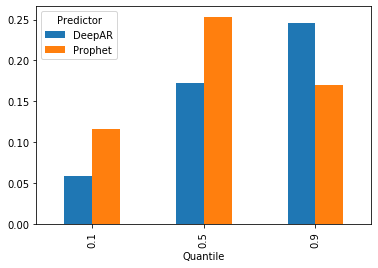

In [81]:
pd.concat([deep_ar_metrics, prophet_metrics]) \
    .pivot(index='Quantile', columns='Predictor', values='LossValue').plot.bar();

As we mentioned before, if you only have a handful of time series (in this case, only 1) with a small number of examples, the neural network models (DeepAR+) are not the best choice. Here, we clearly see that DeepAR+ behaves worse than Prophet in the case of a single time series. 

# Step 5. Creating a Forecast<a class="anchor" id="forecast">

Next we re-train with the full dataset, and create the forecast.

In [82]:
print(f"Done fetching accuracy numbers. Creating forecaster for DeepAR+ ...")

Done fetching accuracy numbers. Creating forecaster for DeepAR+ ...


In [83]:
forecast_name_deep_ar = f'{project}_deep_ar_plus_{idx}'

In [84]:
create_forecast_response_deep_ar = forecast.create_forecast(ForecastName=forecast_name_deep_ar,
                                                        PredictorArn=predictor_arn_deep_ar)

In [85]:
forecast_arn_deep_ar = create_forecast_response_deep_ar['ForecastArn']

In [86]:
status = util.wait(lambda: forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar))
assert status

CREATE_PENDING ..
CREATE_IN_PROGRESS ............................................................................................................................................................................
ACTIVE 


In [87]:
forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar)

{'ForecastArn': 'arn:aws:forecast:us-east-1:457927431838:forecast/bike_rts_demo_bhef__deep_ar_plus_4',
 'ForecastName': 'bike_rts_demo_bhef__deep_ar_plus_4',
 'ForecastTypes': ['0.1', '0.5', '0.9'],
 'PredictorArn': 'arn:aws:forecast:us-east-1:457927431838:predictor/bike_rts_demo_bhef__deep_ar_plus_4',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:457927431838:dataset-group/bike_rts_demo_bhef__gp_4',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 5, 18, 1, 35, 50, 608000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 5, 18, 2, 5, 28, 581000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'd43ecea4-e559-4da9-8c21-7b7bb1d39fad',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 18 May 2020 09:07:36 GMT',
   'x-amzn-requestid': 'd43ecea4-e559-4da9-8c21-7b7bb1d39fad',
   'content-length': '480',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [88]:
print(f"Done fetching accuracy numbers. Creating forecaster for Prophet ...")

Done fetching accuracy numbers. Creating forecaster for Prophet ...


In [89]:
forecast_name_prophet = f'{project}_prophet_{idx}'

In [90]:
create_forecast_response_prophet = forecast.create_forecast(ForecastName=forecast_name_prophet,
                                                        PredictorArn=predictor_arn_prophet)

In [91]:
forecast_arn_prophet = create_forecast_response_prophet['ForecastArn']

In [92]:
status = util.wait(lambda: forecast.describe_forecast(ForecastArn=forecast_arn_prophet))
assert status

CREATE_PENDING .
CREATE_IN_PROGRESS ...........................................................................................................
ACTIVE 


In [93]:
forecast.describe_forecast(ForecastArn=forecast_arn_prophet)

{'ForecastArn': 'arn:aws:forecast:us-east-1:457927431838:forecast/bike_rts_demo_bhef__prophet_4',
 'ForecastName': 'bike_rts_demo_bhef__prophet_4',
 'ForecastTypes': ['0.1', '0.5', '0.9'],
 'PredictorArn': 'arn:aws:forecast:us-east-1:457927431838:predictor/bike_rts_demo_bhef__prophet_4',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:457927431838:dataset-group/bike_rts_demo_bhef__gp_4',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 5, 18, 2, 7, 44, 556000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 5, 18, 2, 26, 16, 489000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '5e10fd66-861e-4a75-b4ed-448aac17821e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 18 May 2020 09:29:23 GMT',
   'x-amzn-requestid': '5e10fd66-861e-4a75-b4ed-448aac17821e',
   'content-length': '465',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

# Step 6. Querying the Forecasts<a class="anchor" id="query">

In [94]:
item_id = 'bike_12'

In [95]:
forecast_response_deep = forecast_query.query_forecast(
    ForecastArn=forecast_arn_deep_ar,
    Filters={"item_id": item_id})

In [96]:
forecast_response_prophet = forecast_query.query_forecast(ForecastArn=forecast_arn_prophet,
                                                     Filters={"item_id":item_id})

In [97]:
fname = f'data/bike_small.csv'
exact = util.load_exact_sol(fname, item_id)

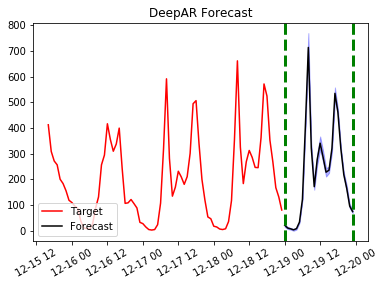

In [98]:
util.plot_forecasts(forecast_response_deep, exact)
plt.title("DeepAR Forecast");

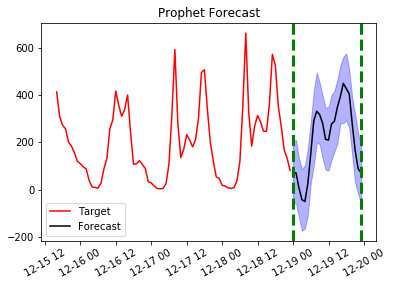

In [99]:
util.plot_forecasts(forecast_response_prophet,exact)
plt.title("Prophet Forecast");

# Step 7. Exporting your Forecasts<a class="anchor" id="export">

In [107]:
forecast_export_name_deep_ar = f'{project}_forecast_export_deep_ar_plus_{idx}'
forecast_export_name_deep_ar_path = f"{s3_data_path}/{forecast_export_name_deep_ar}"

In [108]:
create_forecast_export_response_deep_ar = forecast.create_forecast_export_job(ForecastExportJobName=forecast_export_name_deep_ar,
                                                        ForecastArn=forecast_arn_deep_ar,
                                                        Destination={
                                                            "S3Config" : {
                                                                "Path": forecast_export_name_deep_ar_path,
                                                                "RoleArn": role_arn
                                                            }
                                                        })
forecast_export_arn_deep_ar = create_forecast_export_response_deep_ar['ForecastExportJobArn']

In [109]:
status = util.wait(lambda: forecast.describe_forecast_export_job(ForecastExportJobArn = forecast_export_arn_deep_ar))
assert status

CREATE_PENDING .
CREATE_IN_PROGRESS .....
ACTIVE 


In [110]:
forecast_export_name_prophet = f'{project}_forecast_export_prophet_{idx}'
forecast_export_name_prophet_path = f"{s3_data_path}/{forecast_export_name_prophet}"

In [111]:
create_forecast_export_response_prophet = forecast.create_forecast_export_job(ForecastExportJobName=forecast_export_name_prophet,
                                                        ForecastArn=forecast_arn_prophet,
                                                        Destination={
                                                            "S3Config" : {
                                                                "Path": forecast_export_name_prophet_path,
                                                                "RoleArn": role_arn
                                                            }
                                                        })
forecast_export_arn_prophet = create_forecast_export_response_prophet['ForecastExportJobArn']

In [112]:
status = util.wait(lambda: forecast.describe_forecast_export_job(ForecastExportJobArn = forecast_export_arn_prophet))
assert status

CREATE_PENDING ..
CREATE_IN_PROGRESS ....
ACTIVE 


# Step 8. Cleaning up your Resources<a class="anchor" id="cleanup">

Once we have completed the above steps, we can start to cleanup the resources we created. All delete jobs, except for `delete_dataset_group` are asynchronous, so we have added the helpful `wait_till_delete` function. 
Resource Limits documented <a href="https://docs.aws.amazon.com/forecast/latest/dg/limits.html">here</a>. 

In [113]:
# Delete forecast export for both algorithms
util.wait_till_delete(lambda: forecast.delete_forecast_export_job(ForecastExportJobArn = forecast_export_arn_deep_ar))
util.wait_till_delete(lambda: forecast.delete_forecast_export_job(ForecastExportJobArn = forecast_export_arn_prophet))

Successful delete
Successful delete


In [114]:
# Delete forecast for both algorithms
util.wait_till_delete(lambda: forecast.delete_forecast(ForecastArn = forecast_arn_deep_ar))
util.wait_till_delete(lambda: forecast.delete_forecast(ForecastArn = forecast_arn_prophet))

Successful delete
Successful delete


In [115]:
# Delete predictor for both algorithms
util.wait_till_delete(lambda: forecast.delete_predictor(PredictorArn = predictor_arn_deep_ar))
util.wait_till_delete(lambda: forecast.delete_predictor(PredictorArn = predictor_arn_prophet))

Successful delete
Successful delete


In [116]:
# Delete the target time series and related time series dataset import jobs
util.wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))
util.wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn=rts_dataset_import_job_arn))

Successful delete
Successful delete


In [117]:
# Delete the target time series and related time series datasets
util.wait_till_delete(lambda: forecast.delete_dataset(DatasetArn=ts_dataset_arn))
util.wait_till_delete(lambda: forecast.delete_dataset(DatasetArn=rts_dataset_arn))

Successful delete
Successful delete


In [118]:
# Delete dataset group
forecast.delete_dataset_group(DatasetGroupArn=dataset_group_arn)

{'ResponseMetadata': {'RequestId': 'c6ce8bc7-4052-4fa7-b735-d044de4c7be8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 18 May 2020 09:56:04 GMT',
   'x-amzn-requestid': 'c6ce8bc7-4052-4fa7-b735-d044de4c7be8',
   'content-length': '0',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [119]:
# Delete IAM role
util.delete_iam_role( role_name )